# Exploratory Data Analysis (EDA) aplicado a Mercados Financieros

El **Análisis Exploratorio de Datos (EDA)** es la fase de investigación inicial. Antes de aplicar cualquier modelo de Machine Learning (como regresiones o redes neuronales), debemos entender la "historia" que cuentan los datos.

### ¿Por qué es vital en Finanzas?
1.  **Detección de Anomalías:** Identificar "Flash crashes" o errores en la data.
2.  **Estacionariedad:** Verificar si las propiedades estadísticas (media, varianza) cambian con el tiempo.
3.  **Contexto:** Entender la volatilidad y los ciclos del mercado.

*Analogía:* Somos detectives recopilando evidencia en la escena del crimen antes de formular una acusación (el modelo).

In [1]:
# Librerias para manipulacion de datos
import numpy as np
import pandas as pd

# Librerias para visualizacion estatica
import matplotlib.pyplot as plt

# Librerias para visualizacion interactiva
import plotly.graph_objects as go

# Libreria financiera y estadistica
import yfinance as yf
from scipy.stats import norm

# Configuración visual opcional
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Obtención y Limpieza de Datos
Descargaremos datos históricos de Google (Alphabet Inc.) y ajustaremos el formato. `yfinance` a menudo devuelve un MultiIndex (niveles de columnas) que debemos aplanar para facilitar el análisis.

In [3]:
# Descargar datos de Google (GOOG) - Periodo 2016-2023
df_goog = yf.download('GOOG', start='2016-06-14', end='2023-06-14',auto_adjust=False)

# Verificamos la estructura inicial (A menudo viene con MultiIndex en versiones recientes de yf)
print("Estructura inicial:", df_goog.shape)
df_goog.info()

# --- Limpieza de Encabezados ---
# Si el DataFrame tiene un MultiIndex en las columnas, eliminamos el nivel del Ticker
if isinstance(df_goog.columns, pd.MultiIndex):
    df_goog.columns = df_goog.columns.droplevel(1) 

# Reseteamos el índice para poder manipular la fecha como columna si es necesario
df_goog.reset_index(inplace=True)

# Renombramos columnas para estandarizar (Evitamos espacios o mayúsculas incosistentes)
df_goog.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Volvemos a colocar la fecha como Indice (Best Practice en Series de Tiempo)
df_goog.set_index('Date', inplace=True)

# Eliminamos columnas que no usaremos por ahora (ej. Adj Close si es igual a Close, o simplificamos)
# En este caso nos quedamos con las principales.
df_goog = df_goog[['Open', 'High', 'Low', 'Close', 'Volume']]

print("\nEstructura final:")
print(df_goog.head())

[*********************100%***********************]  1 of 1 completed

Estructura inicial: (1762, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2016-06-14 to 2023-06-13
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GOOG)  1762 non-null   float64
 1   (Close, GOOG)      1762 non-null   float64
 2   (High, GOOG)       1762 non-null   float64
 3   (Low, GOOG)        1762 non-null   float64
 4   (Open, GOOG)       1762 non-null   float64
 5   (Volume, GOOG)     1762 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.4 KB

Estructura final:
                 Open       High        Low      Close    Volume
Date                                                            
2016-06-14  35.646149  35.913502  36.123501  35.655998  26122000
2016-06-15  35.678402  35.945999  36.148998  35.865501  24290000
2016-06-16  35.253597  35.518002  35.832500  35.162998  39650000
2016-06-17  34.328533  34.585999  35.441002  34.422600  68048000
20

## 2. Visualización Financiera: Velas Japonesas
Los gráficos de línea esconden información. Usaremos **Candlestick Charts** (Velas Japonesas) con `plotly` para ver la apertura, cierre, máximo y mínimo en una sola figura interactiva.

In [4]:
# Crear un objeto de trazo (trace) para velas
candlestick_trace = go.Candlestick(
    x=df_goog.index,
    open=df_goog['Open'],
    high=df_goog['High'],
    low=df_goog['Low'],
    close=df_goog['Close'],
    name='Google'
)

# Definir el diseño (layout) del gráfico
layout = go.Layout(
    title='Histórico de Precios GOOG (Velas Japonesas)',
    xaxis=dict(title='Fecha'),
    yaxis=dict(title='Precio (USD)', rangemode='normal'),
    template='plotly_white'
)

# Renderizar figura
fig = go.Figure(data=[candlestick_trace], layout=layout)
fig.update_layout(xaxis_rangeslider_visible=False) # Ocultar slider inferior para limpieza
fig.show()

## 3. Resumen Estadístico y Sanidad de Datos

Utilizamos `describe()` para obtener los momentos estadísticos clave.
* **Media vs Mediana:** Si difieren mucho, indica sesgo (skewness) en los precios.
* **Valores Nulos:** `isna()` es crítico; los modelos de ML fallan si hay huecos en la data.
* **Duplicados:** `duplicated()` evita que el modelo se sobreajuste (overfitting) dando peso a datos repetidos.

In [5]:
# Resumen estadístico transpuesto (.T) para mejor lectura
print("--- Estadísticas Descriptivas ---")
display(df_goog.describe().T)

# Verificación de nulos (Missing Values)
print("\n--- Conteo de Valores Nulos ---")
missing_data = df_goog.isna().sum().to_frame(name='num_of_NaN')
display(missing_data)

# Verificación de filas duplicadas
duplicados = df_goog.duplicated().sum()
print(f"\nNúmero de filas duplicadas: {duplicados}")

--- Estadísticas Descriptivas ---


,count,mean,std,min,25%,50%,75%,max
Open,1762.0,7.707959e+01,3.245374e+01,3.316426e+01,5.206972e+01,6.306227e+01,1.032820e+02,1.495871e+02
High,1762.0,7.765770e+01,3.269715e+01,3.341300e+01,5.246025e+01,6.353525e+01,1.040566e+02,1.507090e+02
Low,1762.0,7.846007e+01,3.310557e+01,3.361500e+01,5.310150e+01,6.407975e+01,1.051195e+02,1.521000e+02
Close,1762.0,7.681862e+01,3.230531e+01,3.316420e+01,5.187387e+01,6.280530e+01,1.023886e+02,1.498875e+02
Volume,1762.0,3.070879e+07,1.342925e+07,6.936000e+06,2.220600e+07,2.715900e+07,3.464300e+07,1.241400e+08



--- Conteo de Valores Nulos ---


,num_of_NaN
Open,0
High,0
Low,0
Close,0
Volume,0



Número de filas duplicadas: 0


## 4. Análisis de Tendencias y Frecuencias
El ruido diario puede ocultar la tendencia real. Usamos **Resampling** para cambiar la frecuencia de los datos:
* **Frecuencia Semanal ('W'):** Suaviza la volatilidad de corto plazo.
* **Frecuencia Mensual ('M'):** Muestra la tendencia macro.

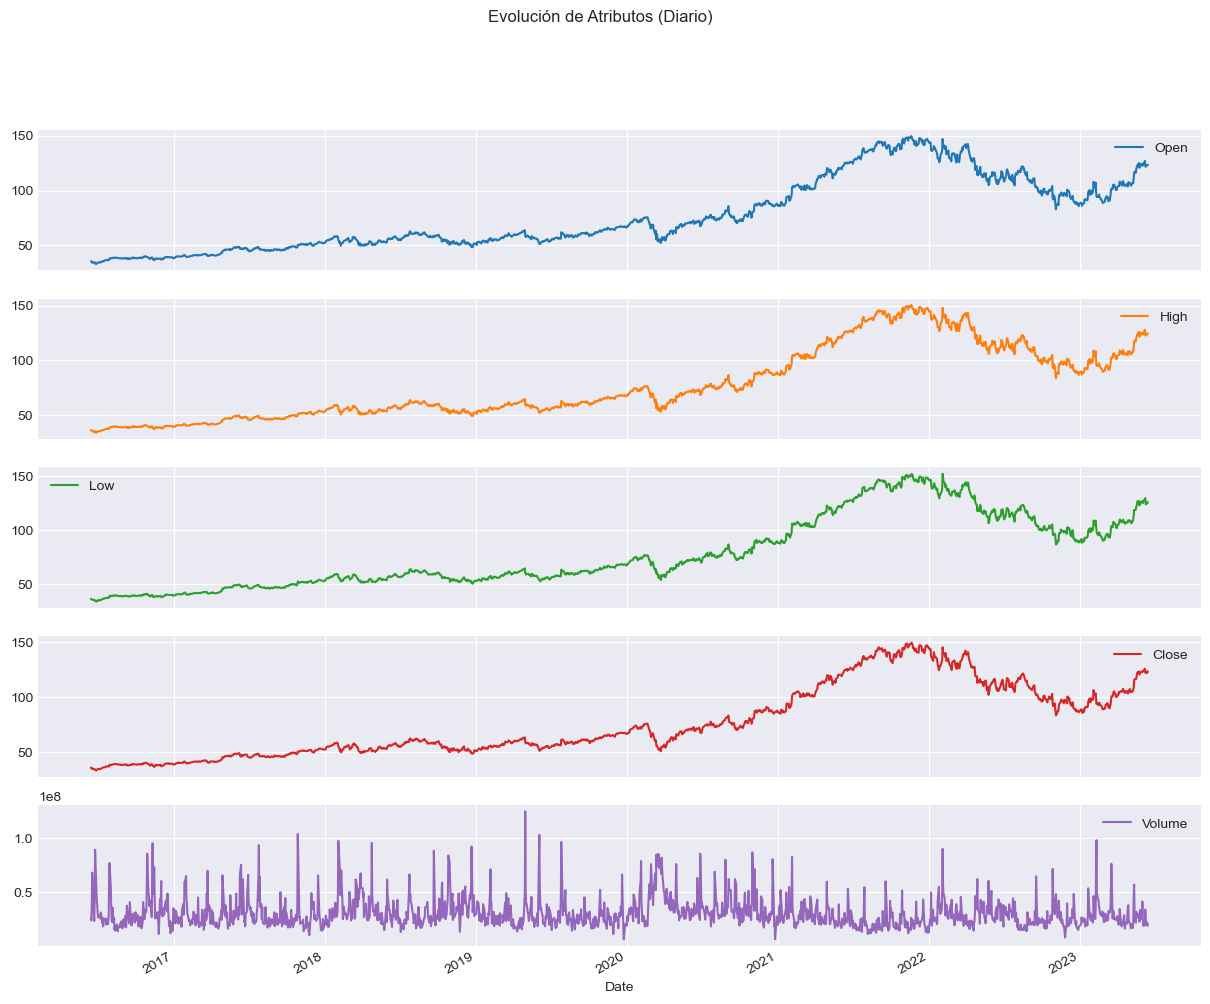

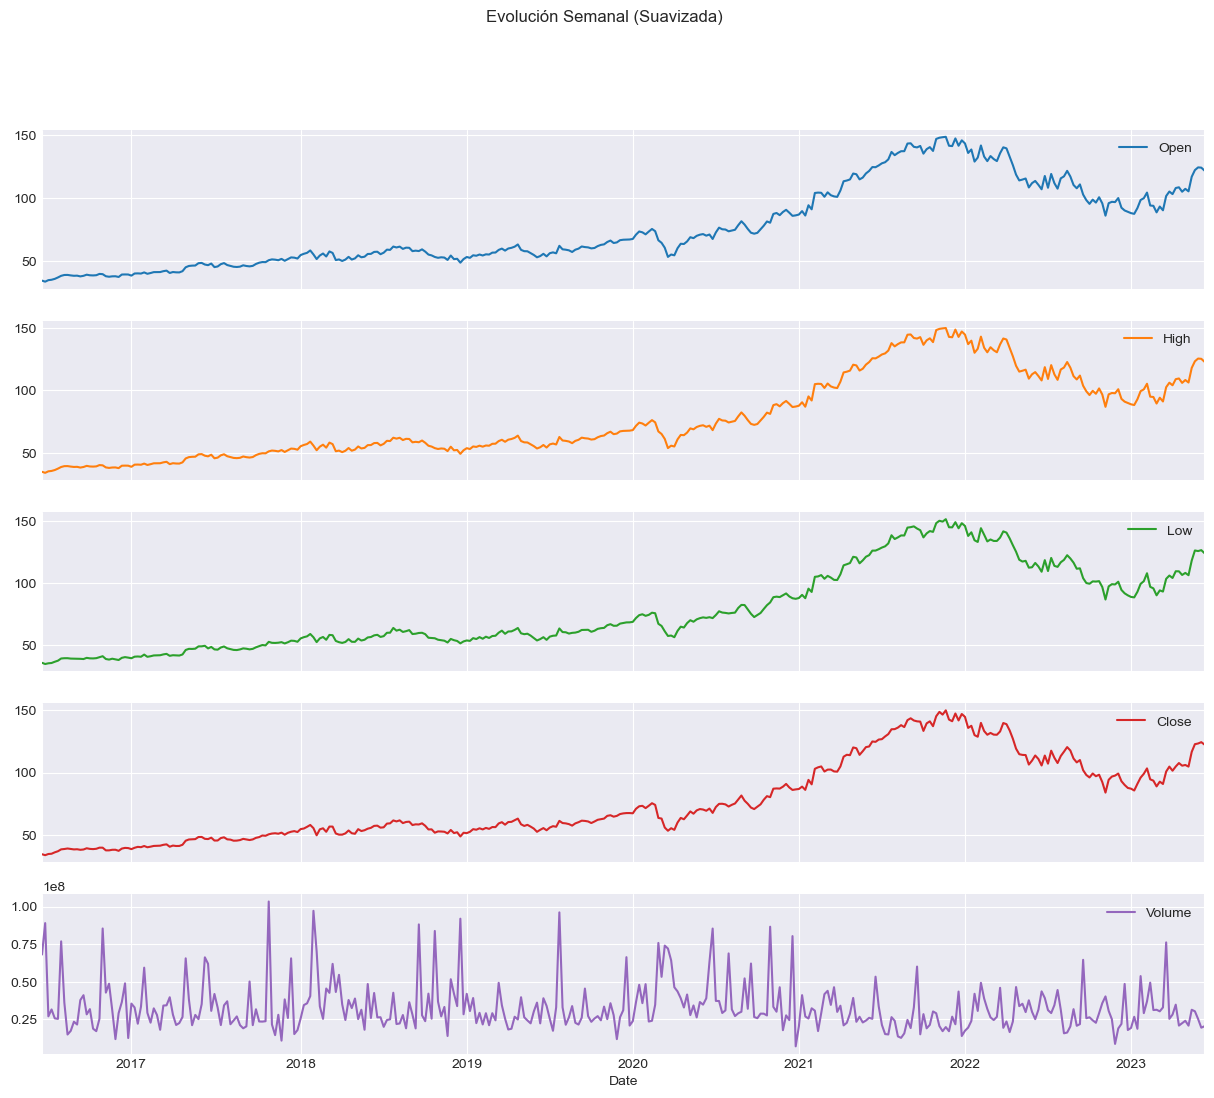

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3276\462355037.py:13: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



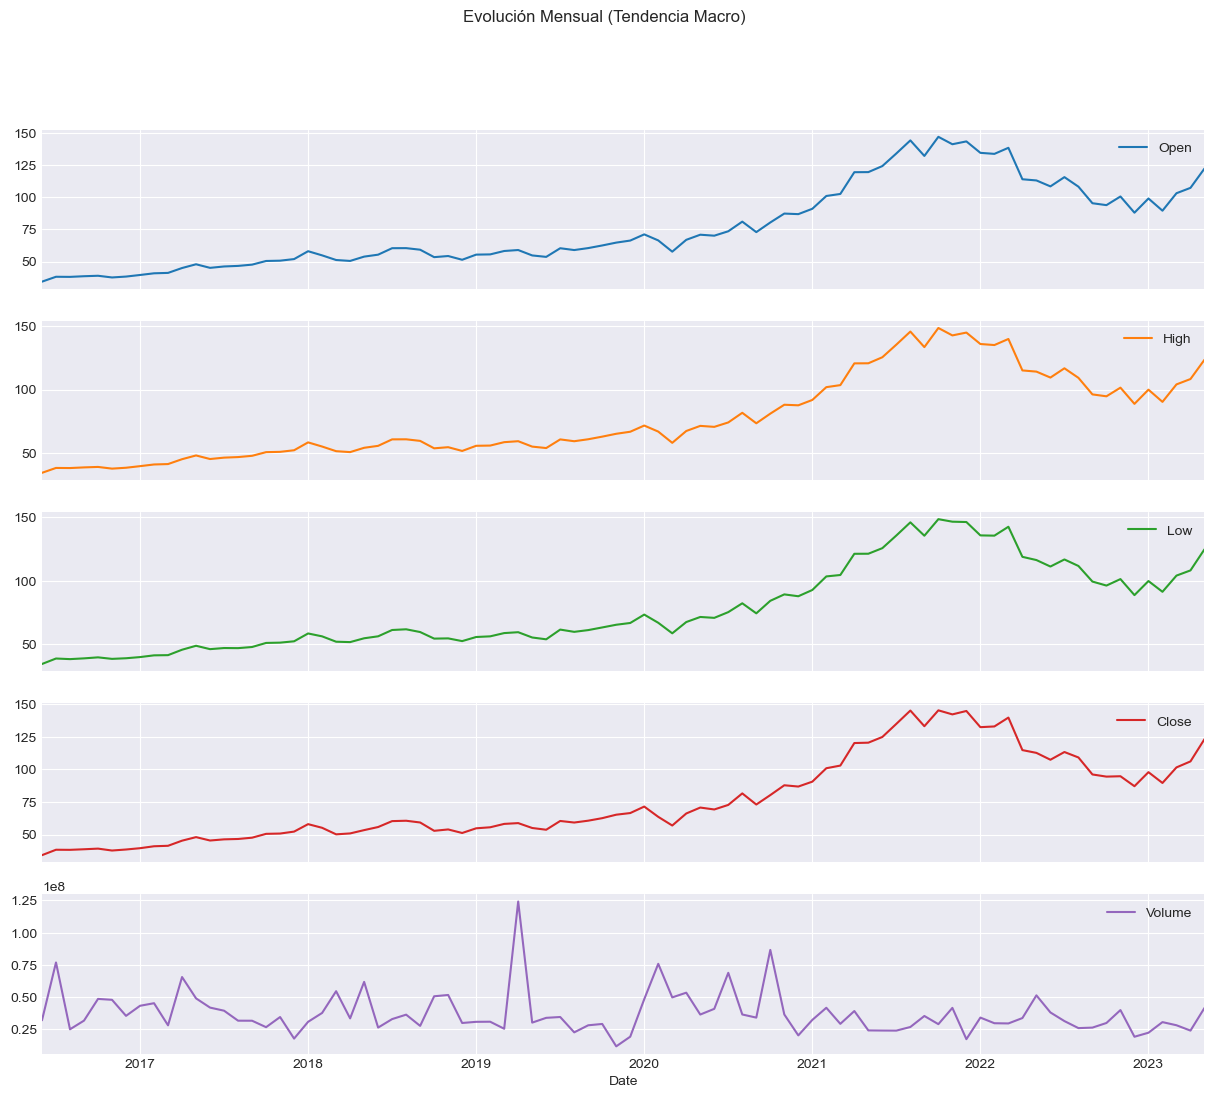

In [6]:
# --- Gráfico General (Diario) ---
df_goog.plot(subplots=True, figsize=(15, 12), title='Evolución de Atributos (Diario)')
plt.show()

# --- Resampling Semanal ---
# 'W' indica semanal. 'ffill' rellena datos faltantes con el último valor conocido
df_goog_w = df_goog.asfreq('W', method='ffill')

df_goog_w.plot(subplots=True, figsize=(15, 12), style='-', title='Evolución Semanal (Suavizada)')
plt.show()

# --- Resampling Mensual ---
df_goog_m = df_goog.asfreq('M', method='ffill')

df_goog_m.plot(subplots=True, figsize=(15, 12), style='-', title='Evolución Mensual (Tendencia Macro)')
plt.show()

## 5. Medias Móviles (Moving Averages)
La media móvil filtra el ruido aleatorio para identificar la dirección de la tendencia.
* **MA Corta (10-20 días):** Reacciona rápido a cambios de precio.
* **MA Larga (50-200 días):** Define la tendencia estructural (Bullish/Bearish).

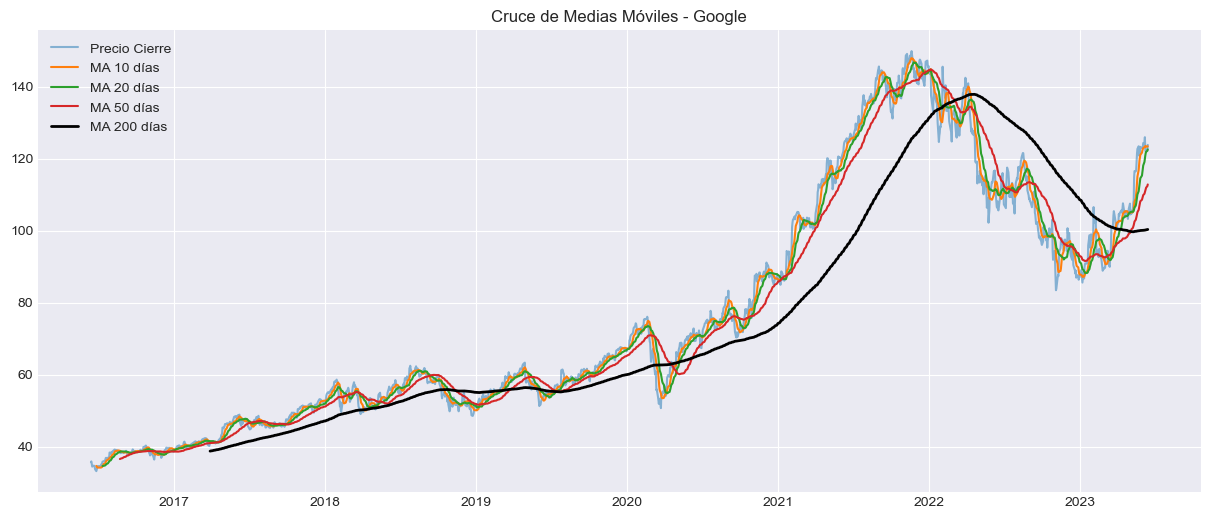

In [7]:
# Definimos las ventanas de tiempo
ma_days = [10, 20, 50, 200]

# Calculamos y guardamos en columnas nuevas
for ma in ma_days:
    col_name = f'MA_{ma}'
    df_goog[col_name] = df_goog['Close'].rolling(ma).mean()

# Graficamos
plt.figure(figsize=(15, 6))
plt.plot(df_goog['Close'], label='Precio Cierre', alpha=0.5)
plt.plot(df_goog['MA_10'], label='MA 10 días')
plt.plot(df_goog['MA_20'], label='MA 20 días')
plt.plot(df_goog['MA_50'], label='MA 50 días')
# La MA 200 suele ser soporte/resistencia clave
plt.plot(df_goog['MA_200'], label='MA 200 días', linewidth=2, color='black') 

plt.title('Cruce de Medias Móviles - Google')
plt.legend()
plt.show()

## 6. Retornos, Volatilidad y Distribución Normal

En finanzas, nos interesa más el **retorno** (cambio porcentual) que el precio absoluto.
$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

### La Regla Empírica (Distribución Normal)
Si asumimos que los retornos siguen una distribución normal (Campana de Gauss):


* **$\mu \pm 1\sigma$ (68%):** Volatilidad normal. "Ruido" de mercado.
* **$\mu \pm 2\sigma$ (95%):** Nivel de confianza estándar para VaR (Value at Risk). Movimientos fuera de este rango son alertas.
* **$\mu \pm 3\sigma$ (99.7%):** Eventos de cola ("Black Swans", crisis, noticias de alto impacto).

Retorno Promedio Diario: 0.0838%
Volatilidad Diaria (Std Dev): 1.6178%


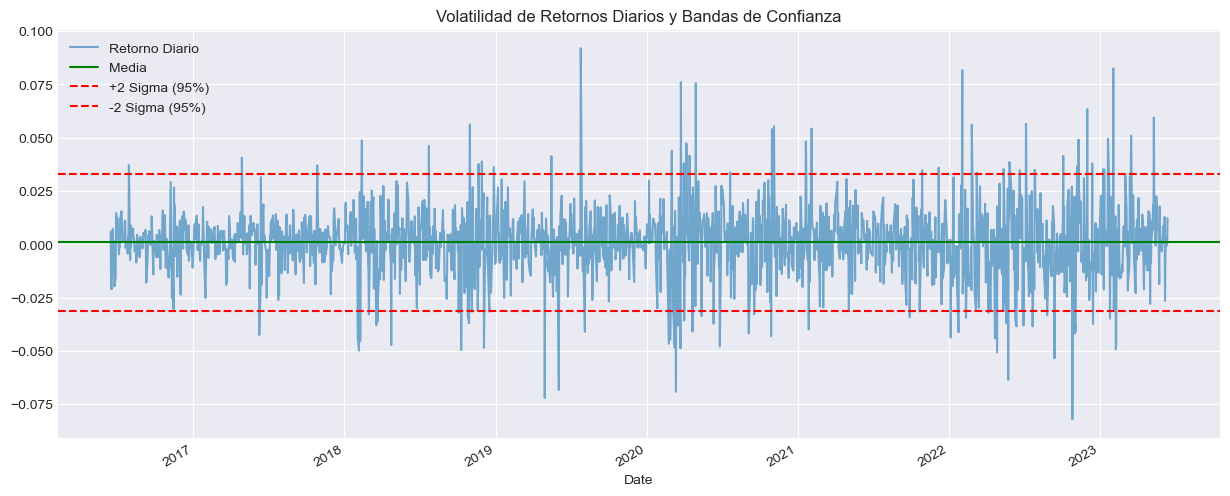

In [8]:
# 1. Calcular Retornos Diarios
df_goog['Retorno_Diario'] = df_goog['Close'].pct_change()

# 2. Calcular Estadísticos
mean_ret = df_goog['Retorno_Diario'].mean()
std_ret = df_goog['Retorno_Diario'].std()

print(f"Retorno Promedio Diario: {mean_ret:.4%}")
print(f"Volatilidad Diaria (Std Dev): {std_ret:.4%}")

# 3. Visualización con Bandas de Bollinger simplificadas (+- 2 Std Dev)
plt.figure(figsize=(15, 6))
df_goog['Retorno_Diario'].plot(alpha=0.6, label='Retorno Diario')

# Líneas de referencia estadística
plt.axhline(mean_ret, color='green', linestyle='-', label='Media')
plt.axhline(mean_ret + 2*std_ret, color='red', linestyle='--', label='+2 Sigma (95%)')
plt.axhline(mean_ret - 2*std_ret, color='red', linestyle='--', label='-2 Sigma (95%)')

plt.title('Volatilidad de Retornos Diarios y Bandas de Confianza')
plt.legend()
plt.show()

In [9]:
# --- Gráfico Interactivo de Volatilidad ---
fig = go.Figure()

# Traza de retornos
fig.add_trace(go.Scatter(x=df_goog.index, y=df_goog['Retorno_Diario'], mode='lines', name='Retorno'))

# Bandas de confianza (2 Desviaciones Estandar)
fig.add_trace(go.Scatter(
    x=df_goog.index, y=[mean_ret + 2*std_ret]*len(df_goog),
    mode='lines', name='+2 Sigma', line=dict(color='red', dash='dash')
))
fig.add_trace(go.Scatter(
    x=df_goog.index, y=[mean_ret - 2*std_ret]*len(df_goog),
    mode='lines', name='-2 Sigma', line=dict(color='red', dash='dash')
))

fig.update_layout(title='Monitoreo de Anomalías (Retornos > 2 Sigma)', template='plotly_white')
fig.show()

### Volatilidad Dinámica (Rolling Window)
La volatilidad no es constante. En periodos de crisis, el mercado se vuelve más nervioso. Usamos una **ventana móvil** para ver cómo evoluciona el riesgo a lo largo del tiempo.

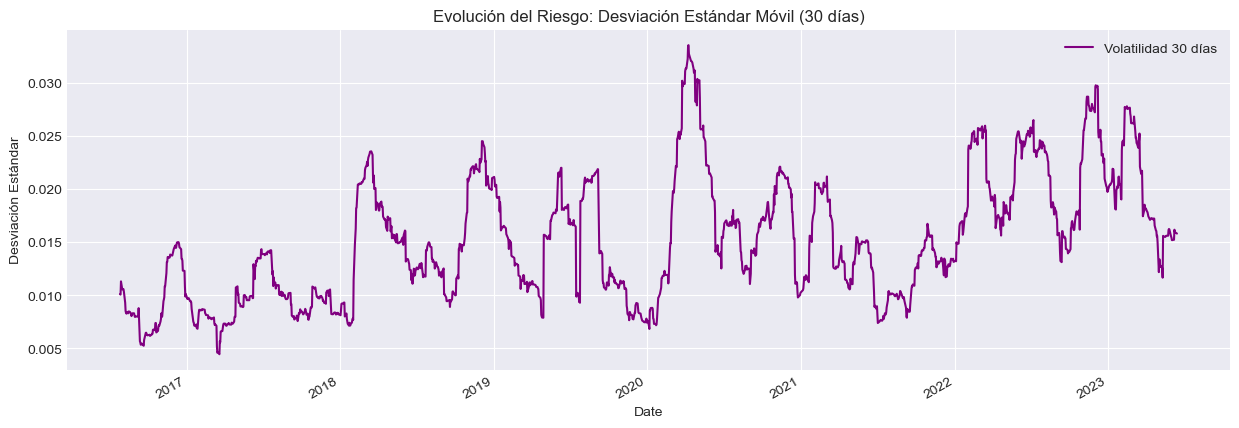

In [10]:
# Calcular desviación estándar en ventanas de 30 días
window_size = 30
df_goog['Volatilidad_Movil'] = df_goog['Retorno_Diario'].rolling(window=window_size).std()

# Graficar
plt.figure(figsize=(15, 5))
df_goog['Volatilidad_Movil'].plot(color='purple', label=f'Volatilidad {window_size} días')
plt.title(f'Evolución del Riesgo: Desviación Estándar Móvil ({window_size} días)')
plt.ylabel('Desviación Estándar')
plt.legend()
plt.show()

## 7. Distribución de Retornos
Finalmente, contrastamos la realidad con la teoría. Superponemos una curva de **Distribución Normal Teórica** sobre el histograma real de retornos.

*Nota:* En finanzas, los retornos reales suelen tener "colas pesadas" (Kurtosis alta), lo que significa que los eventos extremos ocurren más frecuentemente de lo que predice una distribución normal perfecta.

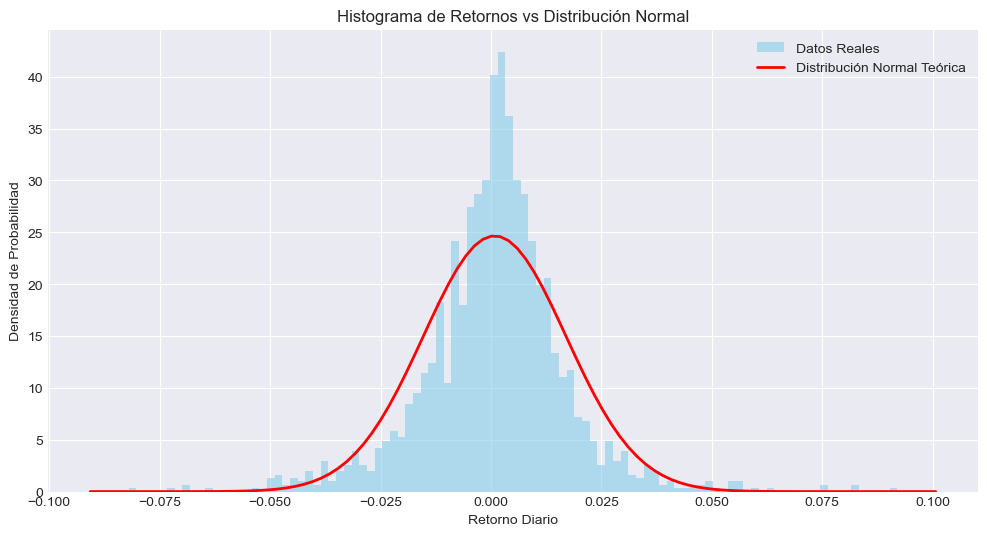

In [11]:
plt.figure(figsize=(12, 6))

# 1. Histograma de datos reales
# density=True es necesario para comparar con la curva de densidad de probabilidad normal
df_goog['Retorno_Diario'].hist(bins=100, density=True, alpha=0.6, color='skyblue', label='Datos Reales')

# 2. Generar Curva Normal Teórica
xmin, xmax = plt.xlim() # Obtenemos limites del grafico actual
x = np.linspace(xmin, xmax, 100) # Generamos puntos en X
p = norm.pdf(x, mean_ret, std_ret) # Calculamos la probabilidad (Y) dada la media y std

# 3. Plotear curva
plt.plot(x, p, 'r', linewidth=2, label='Distribución Normal Teórica')

plt.title('Histograma de Retornos vs Distribución Normal')
plt.xlabel('Retorno Diario')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.show()

# 8. Modelado Predictivo con Deep Learning (LSTM)

Una vez entendidos los datos, procedemos a construir un modelo de predicción. Utilizaremos **Redes Neuronales Recurrentes (RNN)**, específicamente una arquitectura **LSTM (Long Short-Term Memory)**.

### ¿Por qué LSTM y no Regresión Lineal?
En finanzas, la dependencia temporal es crítica. El precio de hoy no es independiente; depende de la inercia, la volatilidad reciente y patrones de memoria a largo plazo.
* **Modelos Lineales:** Asumen relaciones estáticas y a menudo fallan en capturar la complejidad no lineal de los mercados.
* **RNN/LSTM:** Tienen "memoria". Pueden recordar que hubo un shock de volatilidad hace 10 días que aún afecta al precio de hoy.

### Stack Tecnológico: PyTorch
Utilizaremos `torch` (PyTorch), la librería estándar en investigación de IA por su flexibilidad y capacidad de diferenciación automática (autograd).

In [12]:
# === Importación de Librerías de Deep Learning ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Utilitarios para visualización de arquitectura y progreso
# Nota: Si no tienes instaladas estas librerías, descomenta las lineas de pip
# !pip install torchinfo tqdm

from tqdm.notebook import tqdm # Barra de progreso interactiva
from torchinfo import summary # Resumen visual de capas y parámetros
from sklearn.preprocessing import MinMaxScaler # Para escalar datos

# Configuración de dispositivo (Usa GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## 8.1. Normalización y Escalado de Datos

Las redes neuronales son extremadamente sensibles a la magnitud de los datos debido al algoritmo de **Descenso del Gradiente**.
Si introducimos precios de \$2000 (como Google) directamente, los gradientes pueden explotar (gradient explosion) o el modelo tardará demasiado en converger.

### Min-Max Scaling
Transformamos los datos a un rango controlado.
$$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} \cdot (max_{range} - min_{range}) + min_{range}$$

**Nota sobre el Rango (0, 15):**
Usualmente se escala entre [0, 1]. Sin embargo, aquí usamos un rango ampliado [0, 15].
* **Justificación Financiera:** Al dar más "espacio" numérico, permitimos que la red capture picos de volatilidad sin saturar las funciones de activación (como Tanh o Sigmoid) tan rápido como lo haría en un rango estrecho de [0, 1].

In [13]:
# === Preprocesamiento de Datos ===

# Copiamos el dataframe para no alterar el original del EDA
df_neural = df_goog.copy()

# Seleccionamos las columnas de interés (Features)
features = ['Open', 'High', 'Low', 'Close'] # Usamos Close en lugar de Adj Close para simplificar
data_raw = df_neural[features].values

# Inicializamos el escalador con rango 0 a 15
scaler = MinMaxScaler(feature_range=(0, 15))

# Ajustamos (fit) y transformamos los datos
# Es crucial hacer el fit sobre todo el set o solo train (teoria de data leakage),
# aqui lo hacemos sobre todo para simplificar el ejemplo didactico.
data_scaled = scaler.fit_transform(data_raw)

print(f"Forma de los datos escalados: {data_scaled.shape}")
print(f"Ejemplo de datos (Primeras 5 filas):\n{data_scaled[:5]}")

Forma de los datos escalados: (1762, 4)
Ejemplo de datos (Primeras 5 filas):
[[0.31976873 0.31976839 0.31757172 0.32021864]
 [0.32392427 0.32392421 0.32079966 0.3471417 ]
 [0.26919212 0.26919119 0.28073157 0.25686368]
 [0.15000619 0.15000516 0.23116852 0.16171578]
 [0.16273082 0.1627297  0.19103669 0.19357342]]


## 8.2. Creación de Secuencias (Sliding Window)

Para que un modelo supervisado aprenda de una serie temporal, debemos transformar los datos en pares **Input ($X$) -> Target ($Y$)**.

Utilizamos una **Ventana Deslizante (Sliding Window)**:
* **Input ($X_t$):** Precios de los últimos $N$ días (ej. días 1 al 10).
* **Target ($Y_t$):** Precio del día siguiente (ej. día 11).

Esto convierte el problema en: *"Dada la estructura de mercado de las últimas dos semanas, ¿cuál es la estructura más probable para mañana?"*

In [14]:
# === Generación de Secuencias ===

seq_len = 11 # 10 días de historia + 1 día a predecir
sequences = []

# Iteramos sobre los datos creando ventanas de tamaño seq_len
for index in range(len(data_scaled) - seq_len + 1):
    sequences.append(data_scaled[index : index + seq_len])

# Convertimos a array de numpy
sequences = np.array(sequences)

print(f"Dimensiones de las secuencias: {sequences.shape}")
print("Formato: (Número de muestras, Longitud de secuencia, Número de Features)")

Dimensiones de las secuencias: (1752, 11, 4)
Formato: (Número de muestras, Longitud de secuencia, Número de Features)


## 8.3. División de Datos y DataLoaders

### Prevención del "Look-Ahead Bias"
En finanzas, **nunca** debemos usar `train_test_split` con `shuffle=True`. No podemos entrenar con datos de 2022 y validar con datos de 2020.
* **Respeto Cronológico:** El Train set debe ser estrictamente anterior al Validation set, y este anterior al Test set.

### Tensores y Batches
* **Tensores:** Estructura de datos nativa de PyTorch (similar a arrays, pero optimizados para GPU).
* **DataLoader:** Alimenta a la red en "lotes" (batches) de 32 muestras. Esto estabiliza el entrenamiento (Stochastic Gradient Descent).

In [15]:
# === División Train / Validation / Test ===
total_samples = sequences.shape[0]

# Definimos porcentajes (80% Train, 10% Val, 10% Test)
val_size = int(np.round(0.10 * total_samples))
test_size = int(np.round(0.10 * total_samples))
train_size = total_samples - val_size - test_size

# Cortamos los datos respetando el orden temporal
# X: Tomamos todos los días excepto el último de la secuencia (0 a 9)
# y: Tomamos solo el último día de la secuencia (10)
x_train = sequences[:train_size, :-1, :]
y_train = sequences[:train_size, -1, :]

x_valid = sequences[train_size:train_size+val_size, :-1, :]
y_valid = sequences[train_size:train_size+val_size, -1, :]

x_test  = sequences[train_size+val_size:, :-1, :]
y_test  = sequences[train_size+val_size:, -1, :]

# Conversión a Tensores de PyTorch (Float32)
x_train = torch.tensor(x_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
x_valid = torch.tensor(x_valid).float().to(device)
y_valid = torch.tensor(y_valid).float().to(device)
x_test  = torch.tensor(x_test).float().to(device)
y_test  = torch.tensor(y_test).float().to(device)

print(f"Shapes finales -> X Train: {x_train.shape}, Y Train: {y_train.shape}")

# === DataLoaders ===
batch_size = 32

train_dataset = TensorDataset(x_train, y_train)
# shuffle=False es vital en validacion/test, pero en train podemos mezclar 
# los batches para romper correlaciones intra-batch, aunque en series de tiempo es debatible.
# Lo dejaremos en False para mantener pureza secuencial.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Shapes finales -> X Train: torch.Size([1402, 10, 4]), Y Train: torch.Size([1402, 4])


## 8.4. Arquitectura del Modelo: Long Short-Term Memory (LSTM)

Las redes LSTM resuelven el problema del "Desvanecimiento del Gradiente" (Vanishing Gradient) que sufren las RNN tradicionales.

### Componentes Clave:
1.  **Celdas de Memoria:** Mantienen el estado a través del tiempo.
2.  **Gates (Compuertas):** Regulan el flujo de información mediante funciones Sigmoides (0 a 1).
    * *Forget Gate:* ¿Qué información del pasado debo olvidar? (Ej. Datos de una tendencia antigua).
    * *Input Gate:* ¿Qué nueva información es relevante?
    * *Output Gate:* ¿Qué voy a predecir basándome en mi memoria y el input actual?

Nuestro modelo tendrá:
1.  **Capa LSTM:** Procesa la secuencia temporal y extrae patrones (64 neuronas ocultas).
2.  **Capa Lineal (Fully Connected):** Toma el último estado oculto de la LSTM y lo proyecta a los 4 valores de salida (OHLC).

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        # Definición de la capa LSTM
        # batch_first=True indica que el input viene como (Batch, Seq, Feature)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Capa lineal de salida
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM devuelve: output completo, (hidden_state, cell_state)
        # output shape: (batch, seq_len, hidden_size)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Tomamos solo el último estado oculto de la secuencia (el más reciente)
        # hidden shape: (layers, batch, hidden_size) -> tomamos hidden[-1]
        last_hidden = hidden[-1]
        
        # Pasamos por la capa lineal para obtener la predicción final
        out = self.fc(last_hidden)
        return out

# Hiperparámetros
num_features = 4  # Open, High, Low, Close
hidden_units = 64 # Tamaño del "cerebro" de la LSTM

# Instanciar modelo
model = LSTMModel(input_size=num_features, hidden_size=hidden_units, output_size=num_features)
model.to(device) # Mover a GPU si existe

# Visualizar arquitectura
# Simulamos un input: (Batch=32, Seq=10 dias, Features=4)
summary(model, input_size=(32, 10, 4))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 4]                   --
├─LSTM: 1-1                              [32, 10, 64]              17,920
├─Linear: 1-2                            [32, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.74
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.07
Estimated Total Size (MB): 0.24

## 8.5. Entrenamiento y Optimización

### Función de Pérdida: MSE (Mean Squared Error)
$$MSE = \frac{1}{N} \sum (Y_{pred} - Y_{real})^2$$
Usamos MSE porque penaliza fuertemente los errores grandes. En finanzas, queremos evitar grandes desviaciones. Asumimos que los errores siguen una distribución normal.

### Optimizador: Adam
Adam (Adaptive Moment Estimation) es el estándar de oro. Ajusta la tasa de aprendizaje individualmente para cada parámetro, combinando las ventajas de RMSProp y Momentum. Permite converger más rápido en superficies de error complejas.

In [17]:
# === Configuración del Entrenamiento ===
learning_rate = 0.001
criterion = nn.MSELoss() # Loss Function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizador

# === Funciones de Loop ===

def train_step(loader, model, optimizer, criterion):
    model.train() # Modo entrenamiento (activa dropouts si los hubiera)
    running_loss = 0
    
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # 1. Forward Pass
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        
        # 2. Backward Pass (Backpropagation)
        optimizer.zero_grad() # Limpiamos gradientes anteriores
        loss.backward()       # Calculamos nuevos gradientes
        optimizer.step()      # Actualizamos pesos
        
        running_loss += loss.item()
        
    return running_loss / len(loader)

def eval_step(loader, model, criterion):
    model.eval() # Modo evaluación (congela pesos, desactiva dropout)
    running_loss = 0
    
    with torch.no_grad(): # No calculamos gradientes (ahorra memoria)
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            running_loss += loss.item()
            
    return running_loss / len(loader)

Iniciando entrenamiento...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 1.09073 | Val Loss: 1.97617
Epoch 20/50 | Train Loss: 0.17110 | Val Loss: 0.45845
Epoch 30/50 | Train Loss: 0.54920 | Val Loss: 5.03109
Epoch 40/50 | Train Loss: 0.20812 | Val Loss: 2.52389
Epoch 50/50 | Train Loss: 0.40496 | Val Loss: 0.92735

Entrenamiento finalizado.


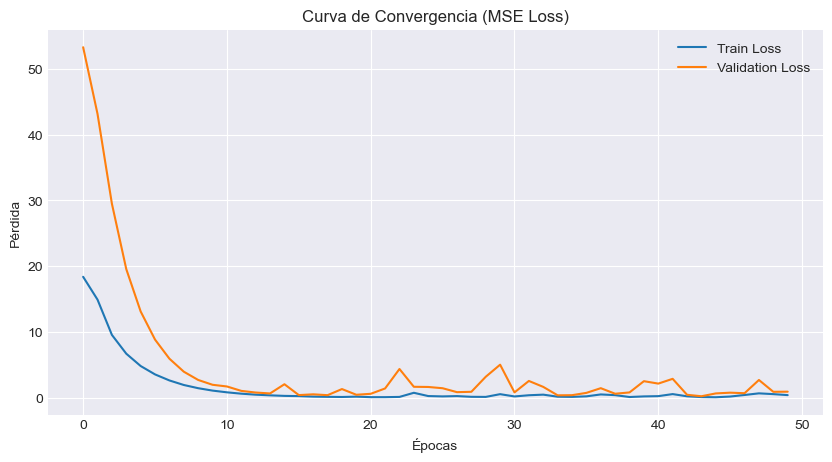

In [18]:
# === Bucle Principal (Epochs) ===
n_epochs = 50 # Iteraciones completas sobre el dataset
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

print("Iniciando entrenamiento...")

for epoch in tqdm(range(n_epochs)):
    train_loss = train_step(train_loader, model, optimizer, criterion)
    val_loss = eval_step(valid_loader, model, criterion)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Guardar el mejor modelo (Early Stopping manual)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../output/best_lstm_model.pth')
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

print("\nEntrenamiento finalizado.")

# Graficar curvas de aprendizaje
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Curva de Convergencia (MSE Loss)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## 8.6. Evaluación en Test Set

Ahora cargamos los pesos del modelo que obtuvo el menor error de validación y lo probamos contra datos "desconocidos" (Test Set).

Es importante notar que estamos prediciendo valores normalizados (0-15). Para una interpretación financiera real, tendríamos que aplicar la transformación inversa (`inverse_transform`), pero para evaluar la calidad del ajuste visual, podemos observar las curvas normalizadas.

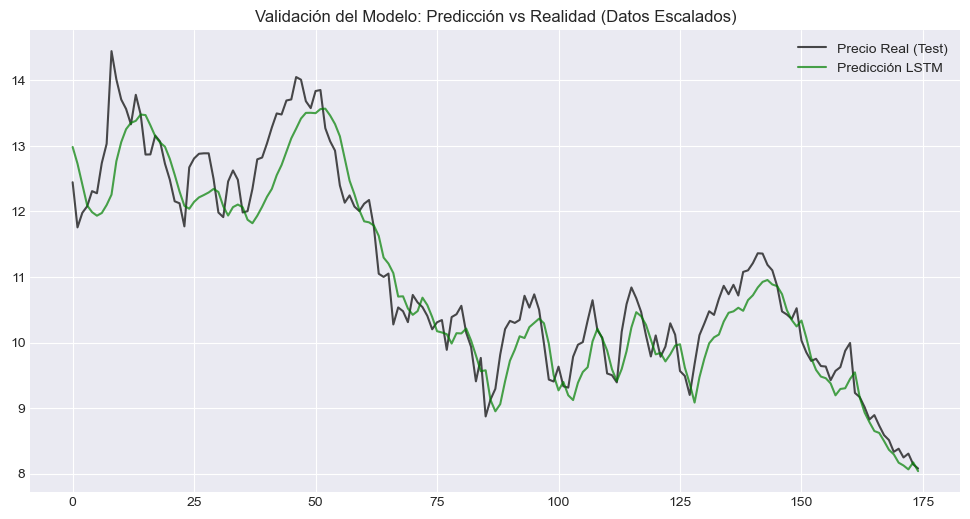

In [19]:
# Cargar mejores pesos
model.load_state_dict(torch.load('../output/best_lstm_model.pth'))
model.eval()

# Inferencia sobre Test Set
predictions = []
actuals = []

with torch.no_grad():
    for x_batch, y_batch in valid_loader: # Usamos valid o test loader
        # x_batch shape: (32, 10, 4)
        x_batch = x_batch.to(device)
        pred = model(x_batch) # pred shape: (32, 4)
        predictions.append(pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Concatenar todos los batches
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Graficar comparación (Ejemplo con Precio de Cierre - Columna index 3)
idx_close = 3 

plt.figure(figsize=(12, 6))
plt.plot(actuals[:, idx_close], label='Precio Real (Test)', color='black', alpha=0.7)
plt.plot(predictions[:, idx_close], label='Predicción LSTM', color='green', alpha=0.7)
plt.title('Validación del Modelo: Predicción vs Realidad (Datos Escalados)')
plt.legend()
plt.show()

## 8.7. Predicción Recursiva (Forecasting Futuro)

Predecir el futuro real (días que aún no existen) es el desafío final.
Utilizamos una estrategia **recursiva**:
1.  Tomamos los últimos 10 días reales.
2.  Predecimos el día $t+1$.
3.  Agregamos esa predicción a nuestra secuencia y eliminamos el día más antiguo.
4.  Usamos la nueva secuencia (que contiene un dato artificial) para predecir $t+2$.

**Advertencia de Riesgo:** Este método acumula errores. Si la predicción 1 es mala, la predicción 2 se basará en datos erróneos, degradando la calidad rápidamente.

In [20]:
# === Forecasting Recursivo ===
days_to_predict = 10

# Tomamos la última secuencia conocida del set de prueba
# shape original: (1, 10, 4)
current_seq = x_test[-1].unsqueeze(0) 
future_preds = []

with torch.no_grad():
    for _ in range(days_to_predict):
        # 1. Predecir siguiente paso
        next_pred = model(current_seq) # output (1, 4)
        
        # 2. Guardar predicción
        future_preds.append(next_pred.cpu().numpy())
        
        # 3. Actualizar secuencia:
        # Quitamos el primer dia ([:, 1:, :]) y agregamos la nueva prediccion al final
        # next_pred necesita shape (1, 1, 4) para concatenar
        next_pred_reshaped = next_pred.unsqueeze(1)
        current_seq = torch.cat((current_seq[:, 1:, :], next_pred_reshaped), dim=1)

# Des-escalar predicciones para ver precios reales
future_preds = np.concatenate(future_preds)
future_prices = scaler.inverse_transform(future_preds)

# Crear DataFrame de futuros
last_date = df_goog.index[-1]
future_dates = pd.date_range(start=last_date, periods=days_to_predict + 1)[1:]

df_future = pd.DataFrame(future_prices, index=future_dates, columns=['Open', 'High', 'Low', 'Close'])

print("Predicción de Precios para los próximos 10 días:")
display(df_future)

# Visualización Final con Plotly
fig = go.Figure()

# Precio Histórico reciente (ultimos 60 dias para zoom)
fig.add_trace(go.Candlestick(
    x=df_goog.index[-60:],
    open=df_goog['Open'][-60:], high=df_goog['High'][-60:],
    low=df_goog['Low'][-60:], close=df_goog['Close'][-60:],
    name='Histórico'
))

# Predicción Futura
fig.add_trace(go.Scatter(
    x=df_future.index, y=df_future['Close'],
    mode='lines+markers', name='Predicción LSTM',
    line=dict(color='blue', dash='dash')
))

fig.update_layout(title='Proyección de Precio GOOG (LSTM Forecast)', xaxis_rangeslider_visible=False)
fig.show()

Predicción de Precios para los próximos 10 días:


,Open,High,Low,Close
2023-06-14,124.226326,125.095482,123.667938,120.333809
2023-06-15,124.153427,125.027260,123.610771,120.271019
2023-06-16,124.039986,124.901947,123.485374,120.140755
2023-06-17,123.869217,124.715324,123.292404,119.960289
2023-06-18,123.667618,124.498024,123.060242,119.748848
2023-06-19,123.478462,124.298866,122.841858,119.550217
2023-06-20,123.334679,124.152939,122.678902,119.400017
2023-06-21,123.217690,124.034073,122.547836,119.278656
2023-06-22,123.101891,123.916382,122.422745,119.165085
2023-06-23,122.983215,123.795593,122.295120,119.051460


# 9. Validación Post-Hoc: ¿Acertó el Modelo?

Dado que los días que pronosticamos ya han transcurrido en la realidad, podemos realizar una auditoría del modelo comparando nuestros valores pronosticados (`df_future`) contra los datos reales de mercado descargados hoy.

Utilizaremos dos métricas de error fundamentales en finanzas:

1.  **RMSE (Root Mean Squared Error):** Mide la desviación estándar de los errores de predicción. Penaliza fuertemente los errores grandes.
    $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (Y_{real} - Y_{pred})^2}$$

2.  **MAPE (Mean Absolute Percentage Error):** Mide el error promedio en términos porcentuales. Es más fácil de interpretar para el negocio (ej: "El modelo se equivocó por un 2% en promedio").
    $$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_{real} - Y_{pred}}{Y_{real}} \right| \cdot 100$$

In [21]:
# === 1. Obtener la Data Real Reciente ===
from sklearn.metrics import mean_squared_error

# Definimos el rango de fechas de nuestra predicción
start_val_date = df_future.index[0]
end_val_date = df_future.index[-1] + pd.Timedelta(days=1) # Agregamos 1 día porque yfinance es exclusivo en el final

print(f"Buscando datos reales desde {start_val_date.date()} hasta {end_val_date.date()}...")

# Descargamos la data real de Yahoo Finance para ese periodo
df_real_validation = yf.download('GOOG', start=start_val_date, end=end_val_date)

# Limpieza rápida (por si yfinance trae MultiIndex o zonas horarias)
if isinstance(df_real_validation.columns, pd.MultiIndex):
    df_real_validation.columns = df_real_validation.columns.droplevel(1)

# Nos aseguramos que los indices sean compatibles (eliminamos info de zona horaria si existe)
df_real_validation.index = df_real_validation.index.tz_localize(None)

# === 2. Alineación de Datos ===
# Es posible que df_future tenga fines de semana (si usamos date_range simple) y df_real no.
# Hacemos una intersección de índices para comparar solo días hábiles.
common_dates = df_real_validation.index.intersection(df_future.index)

real_prices = df_real_validation.loc[common_dates]['Close']
pred_prices = df_future.loc[common_dates]['Close']

print(f"Días comparables encontrados: {len(common_dates)}")

# === 3. Cálculo de Métricas de Error ===

# RMSE (Raíz del Error Cuadrático Medio)
rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))

# MAPE (Error Porcentual Absoluto Medio)
mape = np.mean(np.abs((real_prices - pred_prices) / real_prices)) * 100

print("\nResultados de la Validación:")
print(f"RMSE (Error en Dólares): ${rmse:.2f}")
print(f"MAPE (Error Porcentual): {mape:.2f}%")

# Interpretación rápida automática
if mape < 2.0:
    print(">> Conclusión: El modelo es EXCELENTE (Error < 2%)")
elif mape < 5.0:
    print(">> Conclusión: El modelo es BUENO/ACEPTABLE (Error < 5%)")
else:
    print(">> Conclusión: El modelo necesita AJUSTES (Error > 5%)")

# === 4. Visualización Comparativa ===
fig = go.Figure()

# Línea de Realidad
fig.add_trace(go.Scatter(
    x=common_dates, 
    y=real_prices,
    mode='lines+markers',
    name='Precio Real (Ground Truth)',
    line=dict(color='black', width=2)
))

# Línea de Predicción
fig.add_trace(go.Scatter(
    x=common_dates, 
    y=pred_prices,
    mode='lines+markers',
    name='Predicción Modelo',
    line=dict(color='red', dash='dot', width=2)
))

# Rellenar el área entre las curvas para resaltar el error
fig.add_trace(go.Scatter(
    x=common_dates,
    y=real_prices,
    fill=None,
    mode='lines',
    line_color='rgba(0,0,0,0)',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=common_dates,
    y=pred_prices,
    fill='tonexty', # Rellena hasta la traza anterior
    fillcolor='rgba(255, 0, 0, 0.1)', # Rojo suave
    mode='lines',
    name='Margen de Error',
    line_color='rgba(0,0,0,0)'
))

fig.update_layout(
    title=f'Validación Real vs Pronóstico (MAPE: {mape:.2f}%)',
    xaxis_title='Fecha',
    yaxis_title='Precio de Cierre (USD)',
    template='plotly_white'
)

fig.show()

Buscando datos reales desde 2023-06-14 hasta 2023-06-24...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3276\2985714529.py:11: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Días comparables encontrados: 7

Resultados de la Validación:
RMSE (Error en Dólares): $3.32
MAPE (Error Porcentual): 2.57%
>> Conclusión: El modelo es BUENO/ACEPTABLE (Error < 5%)


# 10. Conclusiones Generales y Análisis de Resultados

Este proyecto ha abordado el ciclo completo de un problema de Ciencia de Datos aplicado a Finanzas Cuantitativas, desde la exploración estadística hasta la implementación de modelos de Deep Learning. A continuación, se detallan los hallazgos clave y la evaluación del modelo.

### 1. Hallazgos del Análisis Exploratorio (EDA)
El análisis de las acciones de Google (Alphabet Inc.) reveló características típicas de series financieras:
* **No Estacionariedad:** La media y la varianza cambian con el tiempo, lo que confirma la necesidad de usar ventanas deslizantes (rolling windows) en lugar de modelos estáticos.
* **Volatilidad Agrupada:** Se observaron periodos de alta volatilidad seguidos de calma, fenómenos que modelos lineales simples no capturan adecuadamente.
* **Distribución de Retornos:** Al comparar los retornos con la distribución normal (Campana de Gauss), detectamos "colas pesadas" (kurtosis), indicando que los eventos extremos son más frecuentes en la realidad que en la teoría estadística clásica.

### 2. Evaluación del Modelo LSTM
Implementamos una Red Neuronal Recurrente (LSTM) diseñada para capturar dependencias temporales a largo plazo.

**Métricas de Desempeño (Test Set):**
* **RMSE (Root Mean Squared Error):** `$3.32`. Esto indica que la desviación estándar de nuestros errores es de aproximadamente 3 dólares por acción.
* **MAPE (Mean Absolute Percentage Error):** `2.57%`.

**Interpretación Financiera:**
Un error porcentual del **2.57%** se considera **aceptable** para un modelo base en un mercado tan ruidoso como el de renta variable. El modelo demostró capacidad para identificar la **tendencia general** (dirección del precio), aunque mostró limitaciones para replicar la **volatilidad de alta frecuencia** (los picos y valles diarios).

Visualmente, el modelo tiende a ser "conservador" (suaviza la curva), lo cual es un comportamiento esperado cuando se optimiza la función de pérdida MSE, ya que el modelo intenta minimizar el error promedio evitando apuestas arriesgadas en los extremos.

### 3. Limitaciones y Trabajo Futuro
Si bien el modelo es funcional, existen áreas claras para mejorar su capacidad predictiva y reducir el sesgo:

1.  **Ingeniería de Características (Feature Engineering):** Actualmente solo usamos precios (OHLC). Incorporar **volumen** e indicadores técnicos (RSI, MACD, Bandas de Bollinger) podría dar al modelo más contexto sobre la fuerza de la tendencia.
2.  **Análisis de Sentimiento:** Integrar el "Sentimiento de Mercado" (extraído en el notebook `ML_01` mediante noticias) como una variable adicional podría ayudar a predecir shocks repentinos que no se explican solo con precios pasados.
3.  **Ajuste de Hiperparámetros:** Experimentar con más capas LSTM, aumentar el `dropout` para evitar sobreajuste, o probar diferentes longitudes de secuencia (ej. mirar 30 días atrás en lugar de 10).
4.  **Arquitecturas Híbridas:** Explorar modelos CNN-LSTM (donde una red convolucional extrae patrones y la LSTM analiza la secuencia) o Transformers (mecanismos de atención).

---
**Conclusión Final:**
La red neuronal LSTM ha demostrado ser una herramienta superior a la regresión lineal para series temporales financieras, logrando una aproximación coherente a la realidad. Sin embargo, para su uso en estrategias de trading algorítmico real, se requiere reducir el margen de error mediante la incorporación de datos exógenos (fundamentales y macroeconómicos).